In [ ]:
import os
import pandas as pd
import numpy as np
from IPython.display import display
from matplotlib import pyplot as plt

from liquidity.util.utils import bin_data_into_quantiles, smooth_outliers
from liquidity.response_functions.features import compute_aggregate_features

from scipy.optimize import least_squares

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
BIN_SIZE = list(range(1, 1000))
OBSERVATION_WINDOWS = [5, 10, 20, 50, 100]

1. Normalize your data daily as you have done in your normalize_by_daily" function.
2. Compute the aggregate impact with the 'compute_conditional_aggregate_ impact function.
3. Remove outliers if necessary to clean your data.
4. Fit your scaling form to the data using fit_scaling_ form' to find the parameters 'RN, 'ON',
"alpha', beta', and 'Const*.
5. Map out scale factors RN and QN and compare against alternative conditonal heavy tailed distributions.
6. Substitute found distribution for RN and QN thereby definining the scaling law and find shape parameters alpha and beta, and rescale paprameters chi and kappa
7. Once you have all parameters, Rescale your data using the found parameter alpha, beta 'chi, and 'kappa' as constants. This involves normalizing the imbalance and return as per the scaling law:

        data = smoothed_aggregate_impact.copy()
        data['vol_imbalance'] = data['vol_imbalance'] / T ** kappa
        result['R'] = result['R'] / T ** chi

8. Plot the rescaled data and observe if they collapse onto a single curve using found scaling law.

## Load data

In [4]:
# TSLA Example
current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..', '..')
data_dir = os.path.join(root_dir, 'data', 'market_orders')
filename = "TSLA-2017-NEW.csv"
stock_file_path = os.path.join(data_dir, filename)
tsla_orderbook_states = pd.read_csv(stock_file_path)

In [5]:
display(tsla_orderbook_states)

,Unnamed: 0,event_timestamp,sign,side,lob_action,order_executed,execution_price,size,ask,bid,...,bid_queue_size_mean,midprice_change,R1,spread,date,daily_R1,daily_vol,daily_num,norm_size,signed_volume
0,0,2017-01-03 10:30:19.351489154,1,ASK,UPDATE,True,219.37,1,219.37,219.28,...,135.963741,0.000,0.000,0.09,2017-01-03,0.021159,277786,3279,0.008043,1
1,1,2017-01-03 10:30:19.351537884,1,ASK,REMOVE,True,219.37,15,219.37,219.28,...,135.963741,0.005,0.005,0.09,2017-01-03,0.021159,277786,3279,0.120647,15
2,2,2017-01-03 10:30:19.351549791,1,ASK,UPDATE,True,219.38,80,219.38,219.28,...,135.963741,0.005,0.005,0.10,2017-01-03,0.021159,277786,3279,0.643452,80
3,3,2017-01-03 10:30:19.351601187,1,ASK,UPDATE,True,219.38,80,219.38,219.29,...,135.963741,0.000,0.000,0.09,2017-01-03,0.021159,277786,3279,0.643452,80
4,4,2017-01-03 10:30:19.351702603,1,ASK,REMOVE,True,219.38,40,219.38,219.29,...,135.963741,0.050,0.050,0.09,2017-01-03,0.021159,277786,3279,0.321726,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1411991,3572,2017-12-29 14:59:11.533706465,1,ASK,REMOVE,True,311.06,321,311.06,311.02,...,151.020334,0.025,0.025,0.04,2017-12-29,0.019713,322243,3577,2.112474,321
1411992,3573,2017-12-29 14:59:50.386983509,-1,BID,REMOVE,True,311.03,200,311.10,311.03,...,151.020334,-0.030,0.030,0.07,2017-12-29,0.019713,322243,3577,1.324325,-200
1411993,3574,2017-12-29 14:59:50.387892067,-1,BID,UPDATE,True,311.02,200,311.05,311.02,...,151.020334,0.000,-0.000,0.03,2017-12-29,0.019713,322243,3577,1.324325,-200
1411994,3575,2017-12-29 14:59:50.387904347,-1,BID,UPDATE,True,311.02,2,311.05,311.02,...,151.020334,0.000,-0.000,0.03,2017-12-29,0.019713,322243,3577,0.013243,-2


## Part $I$: Determine shape parameters in scaling function $\mathscr{F}(x)$

In [6]:
# Compute aggregate features
aggregate_features = compute_aggregate_features(tsla_orderbook_states, BIN_SIZE)
display(aggregate_features)

,event_timestamp,midprice,sign,signed_volume,vol_imbalance,sign_imbalance,daily_R1,daily_vol,daily_num,T
0,2017-01-03 10:30:19.351489154,219.325,1,1,1,1,0.021159,277786,3279,1
1,2017-01-03 10:30:19.351537884,219.325,1,15,15,1,0.021159,277786,3279,1
2,2017-01-03 10:30:19.351549791,219.330,1,80,80,1,0.021159,277786,3279,1
3,2017-01-03 10:30:19.351601187,219.335,1,80,80,1,0.021159,277786,3279,1
4,2017-01-03 10:30:19.351702603,219.335,1,40,40,1,0.021159,277786,3279,1
...,...,...,...,...,...,...,...,...,...,...
2825,2017-12-29 11:36:42.808435367,312.470,-1,-80,2315,-25,0.019713,322243,3577,499
2826,2017-12-29 12:13:57.493780819,312.280,-1,-100,-6909,-91,0.019713,322243,3577,499
2827,2017-12-29 12:56:47.492662398,311.650,1,193,2954,-13,0.019713,322243,3577,499
2828,2017-12-29 13:53:19.050661152,312.485,-1,-45,-8017,-169,0.019713,322243,3577,499


In [7]:
def normalise_by_daily(df: pd.DataFrame) -> pd.DataFrame:
    # TODO: Normalise by average volume at top of queue
    if "vol_imbalance" in df.columns:
        df["vol_imbalance"] = df["vol_imbalance"] / df["daily_vol"]
    if "sign_imbalance" in df.columns:
        df["sign_imbalance"] = df["sign_imbalance"] / df["daily_num"]
    if "R" in df.columns:
        df["R"] = df["R"] / df["daily_R1"]
    return df

In [8]:
def compute_conditional_aggregate_impact(df: pd.DataFrame, normalise: bool = True, log_prices=False) -> pd.DataFrame:

    # TODO: Implement compute_individual_impact (condition on volume and  sign of previous order)
    data = df.copy()
    if type(data["event_timestamp"].iloc[0]) != pd.Timestamp:
        data["event_timestamp"] = data["event_timestamp"].apply(lambda x: pd.Timestamp(x))

    if not log_prices:
        data["R"] = data["midprice"].diff().shift(-1).fillna(0)
    else:
        data["R"] = np.log(data["midprice"].shift(-1).fillna(0)) - np.log(data["midprice"])

    # Normalise data
    if normalise:
        data = normalise_by_daily(data)

    data = data[["T", "vol_imbalance", "R"]]

    return data

In [9]:
# Compute aggregate impact
conditional_aggregate_impact = compute_conditional_aggregate_impact(aggregate_features)[["T", "vol_imbalance", "R"]]

In [10]:
# Remove Outliers for display purposes
smoothed_aggregate_impact = smooth_outliers(conditional_aggregate_impact.copy())
display(smoothed_aggregate_impact)

,T,vol_imbalance,R
0,1,0.000004,0.000000
1,1,0.000054,0.236307
2,1,0.000288,0.236307
3,1,0.000288,0.000000
4,1,0.000144,2.363073
...,...,...,...
2825,499,0.007184,-9.638091
2826,499,-0.015703,-31.957881
2827,499,0.009167,42.356874
2828,499,-0.015703,-58.082181


In [11]:
# USING SCALING FROM EQUATION 3 OF UNIVERSAL PAPER

In [12]:
def scaling_function(x, alpha, beta):
    return x / np.power(1 + np.power(np.abs(x), alpha), beta / alpha)

def scaling_form(orderflow_imbalance, RN, QN, alpha, beta):
    # Extract imbalance and T from the DataFrame
    imbalance = orderflow_imbalance["vol_imbalance"].values
    T = orderflow_imbalance["T"].values

    # Apply the scaling function to the normalized imbalance
    normalized_imbalance = imbalance / (QN * T)
    scaled_imbalance = scaling_function(normalized_imbalance, alpha, beta)

    return (RN * T) * scaled_imbalance


def fit_scaling_form(T_values, vol_imbalance_values, R_values):
    # Define the residuals function
    def residuals(params, T_values, vol_imbalance_values, R_values):
        RN, QN, alpha, beta = params

        # Create DataFrame from T_values and vol_imbalance_values
        orderflow_imbalance = pd.DataFrame({'T': T_values, 'vol_imbalance': vol_imbalance_values})

        # Calculate the model prediction
        predicted = scaling_form(orderflow_imbalance, RN, QN, alpha, beta)

        # Return the residuals
        return R_values - predicted

    # Initial guess for the parameters
    initial_guess = [1, 1, 0.5, 0.5]

    # Perform least squares optimization
    result = least_squares(
        residuals,
        initial_guess,
        args=(T_values, vol_imbalance_values, R_values),
        bounds=([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf]),
        loss='soft_l1',
    )

    return result.x

In [13]:
# FIND SHAPE PARAMETERS

# Prepare the data for fitting
T_values = conditional_aggregate_impact['T'].values
vol_imbalance_values = conditional_aggregate_impact['vol_imbalance'].values
R_values = conditional_aggregate_impact['R'].values

# Perform the fitting
popt = fit_scaling_form(T_values, vol_imbalance_values, R_values)

# Unpack the optimized parameters
RN, QN, alpha, beta = popt
print(f'RN: {RN}')
print(f'QN: {QN}')
print(f'alpha: {alpha}')
print(f'beta: {beta}')

RN: 52.54844441026063
QN: 0.008922910398875147
alpha: 0.35924608305973993
beta: 2.8323010353147


### 2.1. Once $\alpha$ and $\beta$ are fixed, use them map out the scale factors  QN and RN as a functon of T.
  – Once the found shape parameters $\alpha$ and $\beta$ of $\mathscr{F}(x)$ are fixed, we use them to map out scale factors $R_T$ and $\mathcal{E}_T$ by
   fitting the rescaled form $R(ΔV, T)$  as a funtion of $T$, which are accurately described by a power law $R_T \sim T^\chi$ and $\mathcal{E}_T \sim T^\varkappa$.

   – Use the mapped out scale factors $R_T$ and $\mathcal{E}_T$ to extract the rescaling exponents $\chi$ and $\varkappa$ and use them to perform a renomalization
   of the data and functions (curves) to obtain the final master curves.

In [61]:
from liquidity.response_functions.fit import compute_scale_factors

In [62]:
# Compute scale factors using found shape parameters
RN_df, QN_df, RN_fit_object, QN_fit_object, fit_results_per_lag = compute_scale_factors(conditional_aggregate_impact, alpha=alpha, beta=beta)

[]

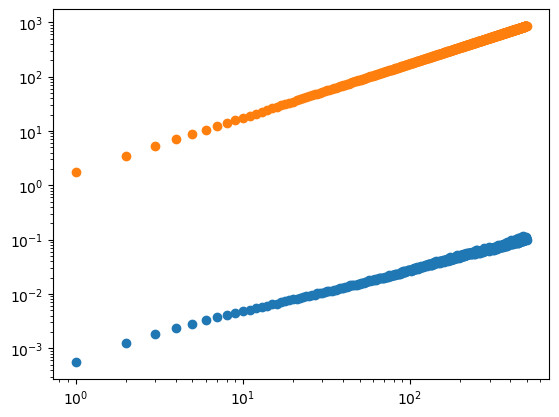

In [63]:
# Plot scale factors RN and QN
plt.scatter(RN_df['x_values'],RN_df['y_values'])
plt.scatter(QN_df['x_values'],QN_df['y_values'])
plt.loglog()

### 2.2. Determine rescaling exponents $\chi$ and $\varkappa$ of scale factors

In [64]:
chi = RN_fit_object.powerlaw.params.alpha
kappa = QN_fit_object.powerlaw.params.alpha
print(chi)
print(kappa)

0.8281428661665762
0.9972980858739302



For powerlaw fitted using MLE:

Pre-fitting parameters;
xmin_index: 10
xmin: 11.0

Fitting parameters;
param_names = ['C', 'alpha']
C = 0.0006071833228383579
alpha = 0.8281428661665762

Goodness of fit to data;
D = 0.032719836400818
bic = -5741.130956225568
mape = 3.1424427656901135
Adjusted R-squared = 0.9903014625175897



For powerlaw fitted using MLE:

Pre-fitting parameters;
xmin_index: 10
xmin: 11.0

Fitting parameters;
param_names = ['C', 'alpha']
C = 1.7500910643500094
alpha = 0.9972980858739302

Goodness of fit to data;
D = 0.00408997955010225
bic = -565.2289845973924
mape = 0.047978601209503494
Adjusted R-squared = 0.9999948267139789




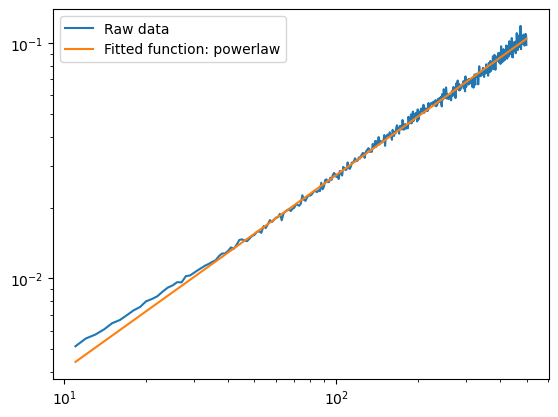

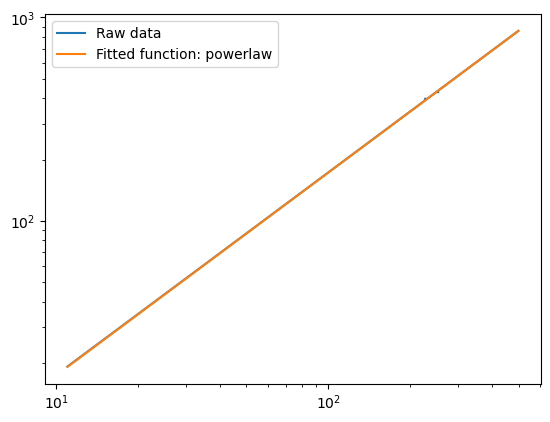

In [65]:
# Fit results
RN_fit_object.powerlaw.fit_results()
QN_fit_object.powerlaw.fit_results()
RN_fit_object.powerlaw.plot_fit()
QN_fit_object.powerlaw.plot_fit()

## Before Collapse

In [19]:
# Plot final rescaled functions
OBSERVATION_WINDOWS = [x for x in OBSERVATION_WINDOWS if x in QN_df['x_values'].values]

In [20]:
fit_param = {}
for T in OBSERVATION_WINDOWS:
    data = conditional_aggregate_impact[conditional_aggregate_impact['T']==T][["T", "vol_imbalance", "R"]]
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    binned_data = bin_data_into_quantiles(data, q=len(BIN_SIZE), duplicates="drop")

    T_values = binned_data['T'].values
    vol_imbalance_values = binned_data['vol_imbalance'].values
    R_values = binned_data['R'].values

    params = fit_scaling_form(T_values, vol_imbalance_values, R_values)
    fit_param[T] = params

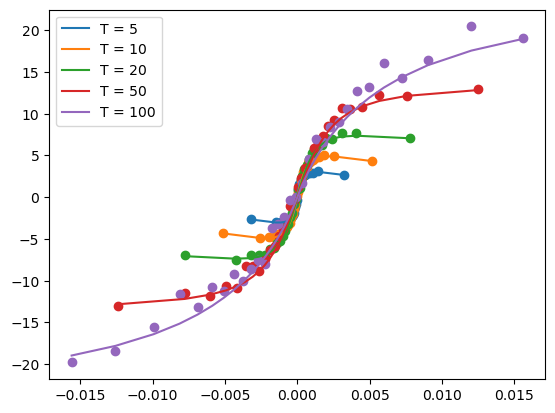

In [21]:
# Plot Before Collapse
for T, param in fit_param.items():
    params = fit_param[T]
    data = smoothed_aggregate_impact[smoothed_aggregate_impact['T']==T][["vol_imbalance", "T", "R"]]
    binned_data = bin_data_into_quantiles(data, q=31, duplicates="drop")

    T_values = binned_data['T'].values
    vol_imbalance_values = binned_data['vol_imbalance'].values
    R_values = binned_data['R'].values

    # Orderflow imblance
    orderflow_imbalance = pd.DataFrame({'T': T_values, 'vol_imbalance': vol_imbalance_values})

    # Compute the model prediction
    model_predictions = scaling_form(orderflow_imbalance, *params)

    plt.scatter(vol_imbalance_values, R_values)
    plt.plot(vol_imbalance_values, model_predictions, label=f"T = {T}")
    plt.legend()

## After Before Collapse

In [50]:
def scaling_function(x, alpha, beta):
    return x / np.power(1 + np.power(np.abs(x), alpha), beta / alpha)

def scaling_law(orderflow_imbalance, chi, kappa, alpha, beta, const):
    imbalance = orderflow_imbalance["vol_imbalance"].values
    T = orderflow_imbalance["T"].values

    rescaled_imbalance = imbalance / np.power(T, kappa)
    scaled_imbalance = scaling_function(rescaled_imbalance, alpha, beta)

    return np.power(T, chi) * scaled_imbalance * const


def fit_scaling_law(T_values, vol_imbalance_values, R_values):

    def residuals(params, T_values, vol_imbalance_values, R_values):

        chi, kappa, alpha, beta, Const = params

        orderflow_imbalance = pd.DataFrame({'T': T_values, 'vol_imbalance': vol_imbalance_values})
        predicted = scaling_law(orderflow_imbalance, chi, kappa, alpha, beta, Const)
        return R_values - predicted

    initial_guess = [1, 1, 0.5, 0.5, 1]

    result = least_squares(
        residuals,
        initial_guess,
        args=(T_values, vol_imbalance_values, R_values),
        bounds=([0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf]),
        loss='soft_l1',
    )

    return result.x

In [51]:
# Prepare the data for fitting
T_values = conditional_aggregate_impact['T'].values
vol_imbalance_values = conditional_aggregate_impact['vol_imbalance'].values
R_values = conditional_aggregate_impact['R'].values

# Fit data for all Ts
master_curve_fit_param = fit_scaling_law(T_values, vol_imbalance_values, R_values)

# Retrieve optimized parameters as constants
CHI, KAPPA, ALPHA, BETA, CONST = master_curve_fit_param
print(f'chi: {CHI}')
print(f'kappa: {KAPPA}')
print(f'alpha: {ALPHA}')
print(f'beta: {BETA}')
print(f'Const: {CONST}')

chi: 0.7082998068525447
kappa: 1.131564418753546
alpha: 0.4109099615641892
beta: 36.20737578375902
Const: 56963.64410748694


In [58]:
from typing import List
class FitResult:
    T: int
    params: List
    data: pd.DataFrame

    def __init__(self, T, params, data):
        self.T = T
        self.params = params
        self.data = data

def transform(conditional_aggregate_impact: pd.DataFrame, master_curve_params, durations, q=100):
    """
    Used for renormalisation and collapse at different scales.
    Hope returns similar params at different scales after renormalisation
    """
    df = conditional_aggregate_impact.copy()

    CHI, KAPPA, ALPHA, BETA, CONST = master_curve_params
    rescale_params = {}
    for T in durations:
        result = df[df["T"] == T][["vol_imbalance", "T", "R"]]

        result["vol_imbalance"] = result["vol_imbalance"] / np.power(T, KAPPA)
        result["R"] = result["R"] / np.power(T, CHI)
        binned_data = bin_data_into_quantiles(result, q=q, duplicates="drop")

        T_values = binned_data['T'].values
        vol_imbalance_values = binned_data['vol_imbalance'].values
        R_values = binned_data['R'].values

        rescale_param = fit_scaling_law(T_values, vol_imbalance_values, R_values)

        if rescale_param[0] is not None:
            rescale_params[T] = FitResult(T, rescale_param, binned_data)
        else:
            print(f"Failed to fit for lag {T}")

    return rescale_params

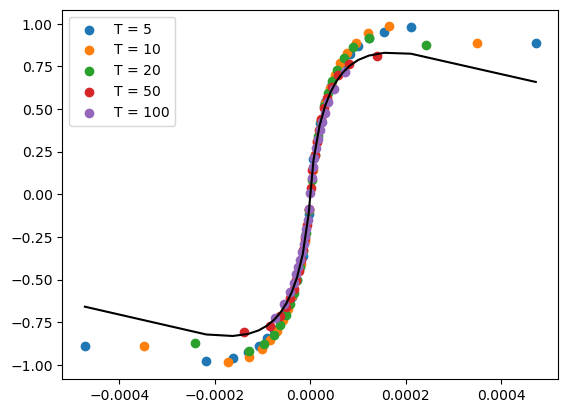

In [60]:
# Plot Before Collapse
rescaled_fit_params = transform(smoothed_aggregate_impact, master_curve_fit_param, OBSERVATION_WINDOWS)

for T, rescaled_param in rescaled_fit_params.items():
    params = rescaled_param.params
    data = rescaled_param.data
    binned_data = bin_data_into_quantiles(data, q=25, duplicates="drop")

    T_values = binned_data['T'].values
    vol_imbalance_values = binned_data['vol_imbalance'].values
    R_values = binned_data['R'].values

    # Orderflow imblance
    orderflow_imbalance = pd.DataFrame({'T': T_values, 'vol_imbalance': vol_imbalance_values})

    # Compute the model prediction
    model_predictions = scaling_law(orderflow_imbalance, *params)

    plt.scatter(vol_imbalance_values, model_predictions, label=f"T = {T}")
    #plt.plot(vol_imbalance_values, model_predictions, label=f"T = {T}")
    plt.legend()

    if T == 5:
        plt.plot(vol_imbalance_values, scaling_function(vol_imbalance_values, master_curve_fit_param[2], master_curve_fit_param[3]) * master_curve_fit_param[-1],
                 '-', linewidth=1.5, color='black')